In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# STEP 1: LOAD AND INSPECT DATA

In [ ]:
df = pd.read_csv('incident_event_log_dataset.csv')

print("*" * 80)
print("INCIDENT MANAGEMENT DATASET - INITIAL INSPECTION")
print("*" * 80)
print(f"\nDataset Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn Information:")
print(df.info())
print(f"\nSample Records:")
print(df.head(10))
print(f"\nNumerical Summary:")
print(df.describe())

********************************************************************************
INCIDENT MANAGEMENT DATASET - INITIAL INSPECTION
********************************************************************************

Dataset Dimensions: 141712 rows × 37 columns

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at   

# STEP 2: EXPLORATORY DATA ANALYSIS


********************************************************************************
EXPLORATORY DATA ANALYSIS
********************************************************************************

>>> SLA Compliance Analysis:
made_sla
True     132497
False      9215
Name: count, dtype: int64

>>> SLA Breach Percentage: 6.50%

>>> Incident State Distribution:
incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64

>>> Workload Metrics:
Mean Reassignments: 1.10
Max Reassignments: 27
Mean Reopens: 0.02
Max Reopens: 8
Mean Modifications: 5.08


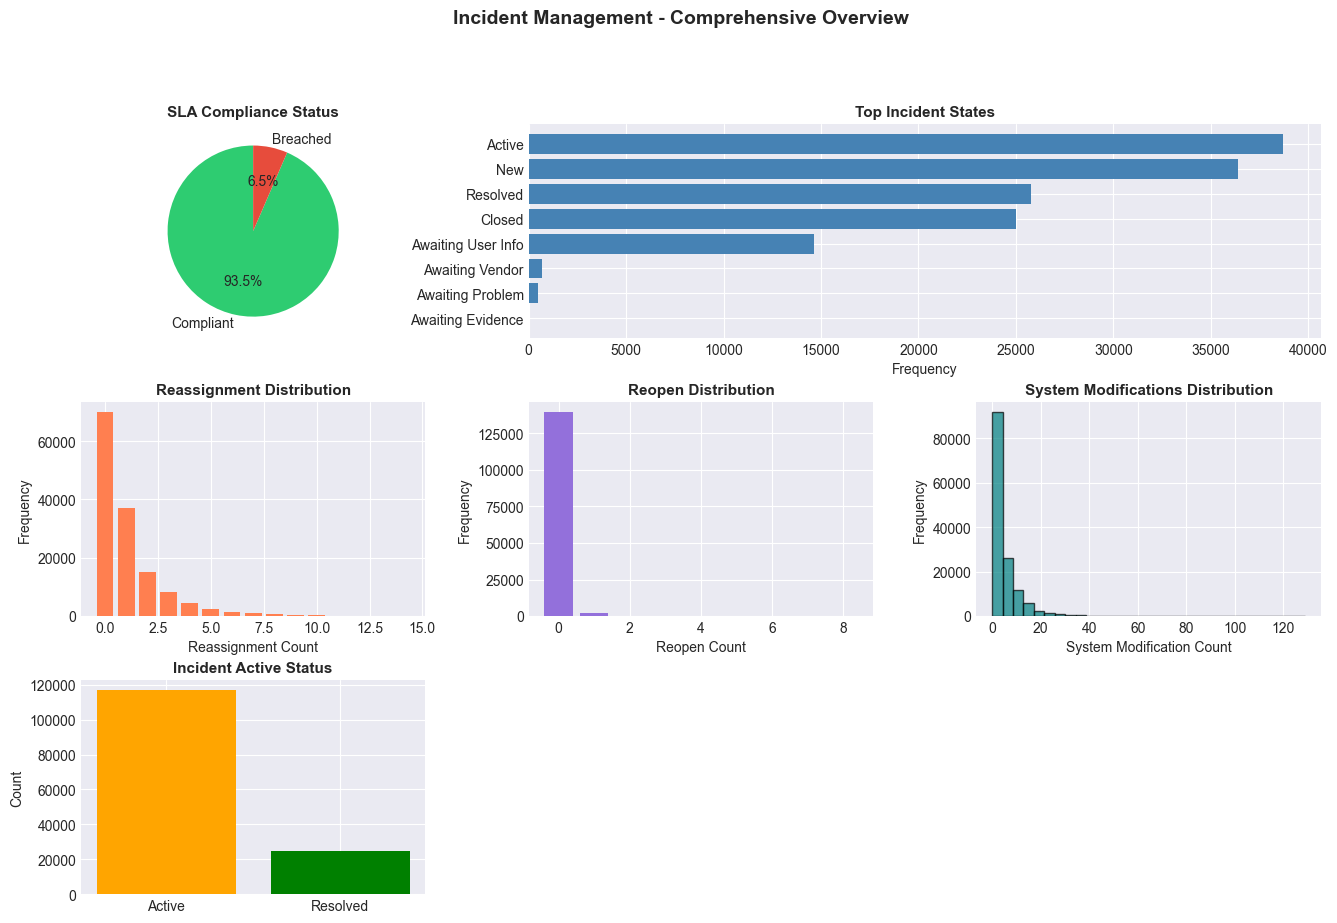

In [3]:
print("\n" + "*" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("*" * 80)

# Analyze SLA compliance
print("\n>>> SLA Compliance Analysis:")
sla_status = df['made_sla'].value_counts()
print(sla_status)
breach_pct = (df['made_sla'] == False).sum() / len(df) * 100
print(f"\n>>> SLA Breach Percentage: {breach_pct:.2f}%")

# Analyze incident lifecycle
print("\n>>> Incident State Distribution:")
print(df['incident_state'].value_counts())

# Analyze workload metrics
print("\n>>> Workload Metrics:")
print(f"Mean Reassignments: {df['reassignment_count'].mean():.2f}")
print(f"Max Reassignments: {df['reassignment_count'].max()}")
print(f"Mean Reopens: {df['reopen_count'].mean():.2f}")
print(f"Max Reopens: {df['reopen_count'].max()}")
print(f"Mean Modifications: {df['sys_mod_count'].mean():.2f}")

# Multi-panel visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# SLA status pie
ax1 = fig.add_subplot(gs[0, 0])
sla_labels = ['Compliant', 'Breached']
sla_colors = ['#2ecc71', '#e74c3c']
ax1.pie(sla_status.values, labels=sla_labels, autopct='%1.1f%%', colors=sla_colors, startangle=90)
ax1.set_title('SLA Compliance Status', fontweight='bold', fontsize=11)

# Incident states
ax2 = fig.add_subplot(gs[0, 1:])
state_counts = df['incident_state'].value_counts().head(8)
ax2.barh(range(len(state_counts)), state_counts.values, color='steelblue')
ax2.set_yticks(range(len(state_counts)))
ax2.set_yticklabels(state_counts.index)
ax2.set_xlabel('Frequency')
ax2.set_title('Top Incident States', fontweight='bold', fontsize=11)
ax2.invert_yaxis()

# Reassignment distribution
ax3 = fig.add_subplot(gs[1, 0])
reassign_data = df['reassignment_count'].value_counts().head(15).sort_index()
ax3.bar(reassign_data.index, reassign_data.values, color='coral')
ax3.set_xlabel('Reassignment Count')
ax3.set_ylabel('Frequency')
ax3.set_title('Reassignment Distribution', fontweight='bold', fontsize=11)

# Reopen distribution
ax4 = fig.add_subplot(gs[1, 1])
reopen_data = df['reopen_count'].value_counts().head(15).sort_index()
ax4.bar(reopen_data.index, reopen_data.values, color='mediumpurple')
ax4.set_xlabel('Reopen Count')
ax4.set_ylabel('Frequency')
ax4.set_title('Reopen Distribution', fontweight='bold', fontsize=11)

# Modification distribution
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(df['sys_mod_count'], bins=30, color='teal', edgecolor='black', alpha=0.7)
ax5.set_xlabel('System Modification Count')
ax5.set_ylabel('Frequency')
ax5.set_title('System Modifications Distribution', fontweight='bold', fontsize=11)

# Active status
ax6 = fig.add_subplot(gs[2, 0])
active_counts = df['active'].value_counts()
ax6.bar(['Active', 'Resolved'], active_counts.values, color=['orange', 'green'])
ax6.set_ylabel('Count')
ax6.set_title('Incident Active Status', fontweight='bold', fontsize=11)

plt.suptitle('Incident Management - Comprehensive Overview', fontsize=14, fontweight='bold', y=0.995)
plt.show()


# STEP 3: DATA QUALITY AUDIT

In [4]:
print("\n" + "*" * 80)
print("DATA QUALITY AUDIT")
print("*" * 80)

# Check for nulls
print("\n>>> Null Value Assessment:")
null_summary = pd.DataFrame({
    'Feature': df.columns,
    'Null_Count': df.isnull().sum(),
    'Null_Percent': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Null_Count', ascending=False)

if null_summary['Null_Count'].sum() > 0:
    print(null_summary[null_summary['Null_Count'] > 0])
else:
    print("✓ No null values detected")

# Check duplicates
dup_count = df.duplicated().sum()
print(f"\n>>> Duplicate Records: {dup_count}")

# Check data types
print("\n>>> Data Type Summary:")
print(df.dtypes.value_counts())

# Outlier detection for numerical columns
print("\n>>> Outlier Detection (IQR Method):")
numerical_cols = ['reassignment_count', 'reopen_count', 'sys_mod_count']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"  {col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")


********************************************************************************
DATA QUALITY AUDIT
********************************************************************************

>>> Null Value Assessment:
✓ No null values detected

>>> Duplicate Records: 0

>>> Data Type Summary:
object    30
bool       4
int64      3
Name: count, dtype: int64

>>> Outlier Detection (IQR Method):
  reassignment_count: 19635 outliers (13.86%)
  reopen_count: 2314 outliers (1.63%)
  sys_mod_count: 10900 outliers (7.69%)


# STEP 4: DATA TRANSFORMATION

In [5]:
print("\n" + "*" * 80)
print("DATA TRANSFORMATION")
print("*" * 80)

df_processed = df.copy()

# Handle nulls with appropriate strategies
print("\n>>> Step 1: Null Value Treatment")
null_cols = df_processed.columns[df_processed.isnull().any()].tolist()
for col in null_cols:
    if df_processed[col].dtype == 'object':
        df_processed[col].fillna('Not_Provided', inplace=True)
        print(f"  ✓ Filled '{col}' nulls with 'Not_Provided'")
    else:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
        print(f"  ✓ Filled '{col}' nulls with median")

# Remove duplicates
print("\n>>> Step 2: Duplicate Removal")
initial_rows = len(df_processed)
df_processed.drop_duplicates(inplace=True)
removed = initial_rows - len(df_processed)
print(f"  ✓ Removed {removed} duplicate entries")

# Parse timestamp
print("\n>>> Step 3: Timestamp Parsing")
if 'opened_at' in df_processed.columns:
    df_processed['opened_at'] = pd.to_datetime(df_processed['opened_at'], 
                                                format='%d-%m-%Y %H:%M', errors='coerce')
    print(f"  ✓ Parsed 'opened_at' column")

# Standardize boolean fields
print("\n>>> Step 4: Boolean Standardization")
bool_fields = ['active', 'made_sla']
for field in bool_fields:
    if field in df_processed.columns:
        df_processed[field] = df_processed[field].astype(str).str.upper().map(
            {'TRUE': 1, 'FALSE': 0}
        )
        print(f"  ✓ Standardized '{field}' to binary (0/1)")

print(f"\n>>> Processed Dataset: {df_processed.shape}")



********************************************************************************
DATA TRANSFORMATION
********************************************************************************

>>> Step 1: Null Value Treatment

>>> Step 2: Duplicate Removal
  ✓ Removed 0 duplicate entries

>>> Step 3: Timestamp Parsing
  ✓ Parsed 'opened_at' column

>>> Step 4: Boolean Standardization
  ✓ Standardized 'active' to binary (0/1)
  ✓ Standardized 'made_sla' to binary (0/1)

>>> Processed Dataset: (141712, 37)


# STEP 5: FEATURE CONSTRUCTION

In [6]:
print("\n" + "*" * 80)
print("FEATURE CONSTRUCTION")
print("*" * 80)

# Build target variable
print("\n>>> Target Variable Creation:")
df_processed['sla_breach'] = 1 - df_processed['made_sla']
breach_rate = df_processed['sla_breach'].mean() * 100
print(f"  ✓ Created 'sla_breach' target (Breach Rate: {breach_rate:.2f}%)")

# Temporal feature extraction
print("\n>>> Temporal Feature Extraction:")
if df_processed['opened_at'].notna().any():
    df_processed['open_hour'] = df_processed['opened_at'].dt.hour
    df_processed['open_day'] = df_processed['opened_at'].dt.dayofweek
    df_processed['open_month'] = df_processed['opened_at'].dt.month
    df_processed['is_business_hours'] = ((df_processed['open_hour'] >= 9) & 
                                         (df_processed['open_hour'] <= 17)).astype(int)
    df_processed['is_weekday'] = (df_processed['open_day'] < 5).astype(int)
    print(f"  ✓ Extracted: open_hour, open_day, open_month, is_business_hours, is_weekday")

# Engineering derived metrics
print("\n>>> Derived Metric Engineering:")
df_processed['workload_score'] = (df_processed['reassignment_count'] + 
                                   df_processed['reopen_count'] + 
                                   df_processed['sys_mod_count'] / 10)
df_processed['complexity_flag'] = (df_processed['workload_score'] > 
                                   df_processed['workload_score'].quantile(0.75)).astype(int)
df_processed['reassigned'] = (df_processed['reassignment_count'] > 0).astype(int)
df_processed['reopened'] = (df_processed['reopen_count'] > 0).astype(int)
print(f"  ✓ Created: workload_score, complexity_flag, reassigned, reopened")

# Categorical encoding
print("\n>>> Categorical Variable Encoding:")
cat_features = ['incident_state', 'caller_id', 'opened_by']
label_encoders = {}
for feature in cat_features:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_code'] = le.fit_transform(df_processed[feature].astype(str))
        label_encoders[feature] = le
        unique_vals = df_processed[feature].nunique()
        print(f"  ✓ Encoded '{feature}' ({unique_vals} categories) → '{feature}_code'")

print(f"\n>>> Feature Count: {df_processed.shape[1]} total features")


********************************************************************************
FEATURE CONSTRUCTION
********************************************************************************

>>> Target Variable Creation:
  ✓ Created 'sla_breach' target (Breach Rate: 6.50%)

>>> Temporal Feature Extraction:
  ✓ Extracted: open_hour, open_day, open_month, is_business_hours, is_weekday

>>> Derived Metric Engineering:
  ✓ Created: workload_score, complexity_flag, reassigned, reopened

>>> Categorical Variable Encoding:
  ✓ Encoded 'incident_state' (9 categories) → 'incident_state_code'
  ✓ Encoded 'caller_id' (5245 categories) → 'caller_id_code'
  ✓ Encoded 'opened_by' (208 categories) → 'opened_by_code'

>>> Feature Count: 50 total features


# STEP 6: SLA BREACH PATTERN INVESTIGATION


********************************************************************************
SLA BREACH PATTERN INVESTIGATION
********************************************************************************

>>> Comparative Statistics:
  Reassignments:
    Compliant: 1.06 | Breached: 1.69 | Δ: 0.63 (+58.9%)
  Reopens:
    Compliant: 0.02 | Breached: 0.03 | Δ: 0.01 (+63.4%)
  Modifications:
    Compliant: 4.59 | Breached: 12.13 | Δ: 7.54 (+164.2%)
  Workload Score:
    Compliant: 1.54 | Breached: 2.94 | Δ: 1.39 (+90.3%)

>>> Breach Distribution by State:
incident_state
Closed                9154
Active                  28
Awaiting User Info      20
Resolved                10
Awaiting Vendor          2
Awaiting Problem         1
Name: count, dtype: int64


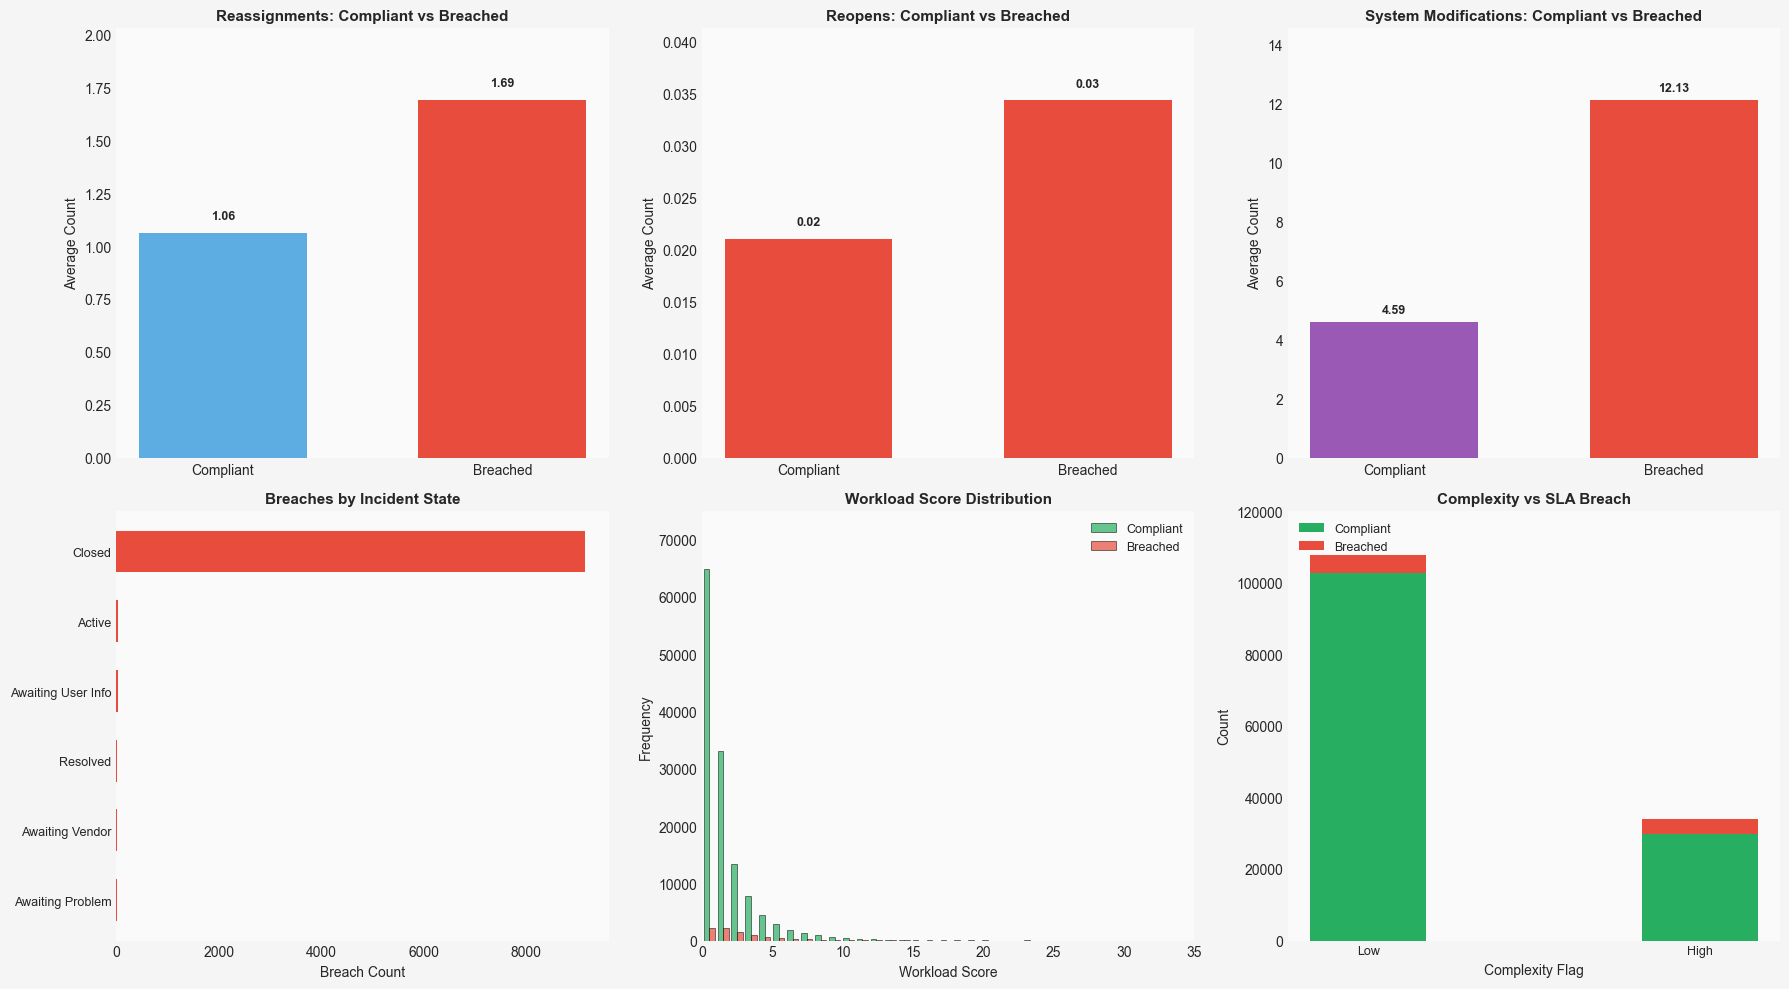

In [8]:
#==============================================================================
# STEP 6: SLA BREACH PATTERN INVESTIGATION
#==============================================================================

print("\n" + "*" * 80)
print("SLA BREACH PATTERN INVESTIGATION")
print("*" * 80)

breach_incidents = df_processed[df_processed['sla_breach'] == 1]
compliant_incidents = df_processed[df_processed['sla_breach'] == 0]

print("\n>>> Comparative Statistics:")
comparison_metrics = {
    'Reassignments': (compliant_incidents['reassignment_count'].mean(), 
                      breach_incidents['reassignment_count'].mean()),
    'Reopens': (compliant_incidents['reopen_count'].mean(), 
                breach_incidents['reopen_count'].mean()),
    'Modifications': (compliant_incidents['sys_mod_count'].mean(), 
                      breach_incidents['sys_mod_count'].mean()),
    'Workload Score': (compliant_incidents['workload_score'].mean(), 
                       breach_incidents['workload_score'].mean())
}

for metric, (compliant_val, breach_val) in comparison_metrics.items():
    diff = breach_val - compliant_val
    pct_diff = (diff / compliant_val * 100) if compliant_val > 0 else 0
    print(f"  {metric}:")
    print(f"    Compliant: {compliant_val:.2f} | Breached: {breach_val:.2f} | Δ: {diff:.2f} ({pct_diff:+.1f}%)")

print("\n>>> Breach Distribution by State:")
breach_by_state = breach_incidents['incident_state'].value_counts().head(6)
print(breach_by_state)

# Create the 6-panel visualization matching the chart
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.patch.set_facecolor('#f5f5f5')

# Panel 1: Reassignments Comparison
reassign_means = [compliant_incidents['reassignment_count'].mean(), 
                  breach_incidents['reassignment_count'].mean()]
bars1 = axes[0, 0].bar(['Compliant', 'Breached'], reassign_means, 
                       color=['#5DADE2', '#E74C3C'], width=0.6)
axes[0, 0].set_ylabel('Average Count', fontsize=10)
axes[0, 0].set_title('Reassignments: Compliant vs Breached', fontweight='bold', fontsize=11)
axes[0, 0].set_ylim(0, max(reassign_means) * 1.2)
for i, (bar, val) in enumerate(zip(bars1, reassign_means)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel 2: Reopens Comparison
reopen_means = [compliant_incidents['reopen_count'].mean(), 
                breach_incidents['reopen_count'].mean()]
bars2 = axes[0, 1].bar(['Compliant', 'Breached'], reopen_means, 
                       color=['#E74C3C', '#E74C3C'], width=0.6)
axes[0, 1].set_ylabel('Average Count', fontsize=10)
axes[0, 1].set_title('Reopens: Compliant vs Breached', fontweight='bold', fontsize=11)
axes[0, 1].set_ylim(0, max(reopen_means) * 1.2)
for i, (bar, val) in enumerate(zip(bars2, reopen_means)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, val + 0.001, f'{val:.2f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel 3: System Modifications Comparison
sysmod_means = [compliant_incidents['sys_mod_count'].mean(), 
                breach_incidents['sys_mod_count'].mean()]
bars3 = axes[0, 2].bar(['Compliant', 'Breached'], sysmod_means, 
                       color=['#9B59B6', '#E74C3C'], width=0.6)
axes[0, 2].set_ylabel('Average Count', fontsize=10)
axes[0, 2].set_title('System Modifications: Compliant vs Breached', fontweight='bold', fontsize=11)
axes[0, 2].set_ylim(0, max(sysmod_means) * 1.2)
for i, (bar, val) in enumerate(zip(bars3, sysmod_means)):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.2f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel 4: Breaches by Incident State
breach_state_counts = breach_by_state.values
breach_state_labels = breach_by_state.index
y_positions = range(len(breach_state_labels))
axes[1, 0].barh(y_positions, breach_state_counts, color='#E74C3C', height=0.6)
axes[1, 0].set_yticks(y_positions)
axes[1, 0].set_yticklabels(breach_state_labels, fontsize=9)
axes[1, 0].set_xlabel('Breach Count', fontsize=10)
axes[1, 0].set_title('Breaches by Incident State', fontweight='bold', fontsize=11)
axes[1, 0].invert_yaxis()

# Panel 5: Workload Score Distribution
axes[1, 1].hist([compliant_incidents['workload_score'], breach_incidents['workload_score']], 
                bins=35, label=['Compliant', 'Breached'], 
                color=['#27AE60', '#E74C3C'], alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Workload Score', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Workload Score Distribution', fontweight='bold', fontsize=11)
axes[1, 1].legend(loc='upper right', fontsize=9)
axes[1, 1].set_xlim(0, 35)
axes[1, 1].set_ylim(0, 75000)

# Panel 6: Complexity vs SLA Breach
complexity_cross = pd.crosstab(df_processed['complexity_flag'], df_processed['sla_breach'])
x_pos = [0, 1]
width = 0.35
axes[1, 2].bar(x_pos, complexity_cross[0], width, label='Compliant', color='#27AE60')
axes[1, 2].bar(x_pos, complexity_cross[1], width, bottom=complexity_cross[0], 
               label='Breached', color='#E74C3C')
axes[1, 2].set_ylabel('Count', fontsize=10)
axes[1, 2].set_xlabel('Complexity Flag', fontsize=10)
axes[1, 2].set_title('Complexity vs SLA Breach', fontweight='bold', fontsize=11)
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['Low', 'High'], fontsize=9)
axes[1, 2].legend(loc='upper left', fontsize=9)
axes[1, 2].set_ylim(0, 120000)

# Overall styling
for ax in axes.flat:
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    ax.set_facecolor('#fafafa')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# STEP 7: FEATURE NORMALIZATION

In [10]:
#==============================================================================
# STEP 7: FEATURE NORMALIZATION
#==============================================================================

print("\n" + "*" * 80)
print("FEATURE NORMALIZATION")
print("*" * 80)

# Select base numerical features
scale_features = []

# Add core metrics
numeric_base = ['reassignment_count', 'reopen_count', 'sys_mod_count', 'workload_score']
for col in numeric_base:
    if col in df_processed.columns:
        scale_features.append(col)

# Add encoded features (must be numeric)
encoded_cols = [col for col in df_processed.columns if col.endswith('_code')]
for col in encoded_cols:
    if col in df_processed.columns and pd.api.types.is_numeric_dtype(df_processed[col]):
        scale_features.append(col)

# Add temporal features if they exist
temporal_features = ['open_hour', 'open_day', 'open_month']
for feat in temporal_features:
    if feat in df_processed.columns and pd.api.types.is_numeric_dtype(df_processed[feat]):
        scale_features.append(feat)

print(f"\n>>> Selected {len(scale_features)} numeric features for normalization")

# Check for any remaining non-numeric data
print("\n>>> Validating feature types:")
valid_features = []
for feat in scale_features:
    if pd.api.types.is_numeric_dtype(df_processed[feat]):
        valid_features.append(feat)
        print(f"  ✓ {feat}: {df_processed[feat].dtype}")
    else:
        print(f"  ✗ {feat}: {df_processed[feat].dtype} (SKIPPED - not numeric)")

scale_features = valid_features

if len(scale_features) == 0:
    print("\n  ⚠ WARNING: No numeric features found for scaling!")
else:
    print(f"\n>>> Applying Min-Max Normalization to {len(scale_features)} features")
    
    normalizer = MinMaxScaler()
    df_processed[scale_features] = normalizer.fit_transform(df_processed[scale_features])
    
    print(f"  ✓ Normalized features to [0, 1] range")
    print(f"\n>>> Normalized statistics:")
    print(df_processed[scale_features].describe().loc[['min', 'max', 'mean']].round(3))


********************************************************************************
FEATURE NORMALIZATION
********************************************************************************

>>> Selected 10 numeric features for normalization

>>> Validating feature types:
  ✓ reassignment_count: int64
  ✓ reopen_count: int64
  ✓ sys_mod_count: int64
  ✓ workload_score: float64
  ✓ incident_state_code: int32
  ✓ caller_id_code: int32
  ✓ opened_by_code: int32
  ✓ open_hour: int32
  ✓ open_day: int32
  ✓ open_month: int32

>>> Applying Min-Max Normalization to 10 features
  ✓ Normalized features to [0, 1] range

>>> Normalized statistics:
      reassignment_count  reopen_count  sys_mod_count  workload_score  \
min                0.000         0.000          0.000           0.000   
max                1.000         1.000          1.000           1.000   
mean               0.041         0.003          0.039           0.047   

      incident_state_code  caller_id_code  opened_by_code  open_hou

# STEP 8: CORRELATION & FEATURE IMPORTANCE


********************************************************************************
CORRELATION & FEATURE IMPORTANCE
********************************************************************************

>>> Features Most Correlated with SLA Breach:
sla_breach             1.000000
sys_mod_count          0.241942
workload_score         0.150051
complexity_flag        0.130904
incident_state_code    0.092585
reassigned             0.091232
reassignment_count     0.089037
opened_by_code         0.028612
reopened               0.026314
reopen_count           0.015880
is_weekday             0.014750
open_hour              0.012541
Name: sla_breach, dtype: float64


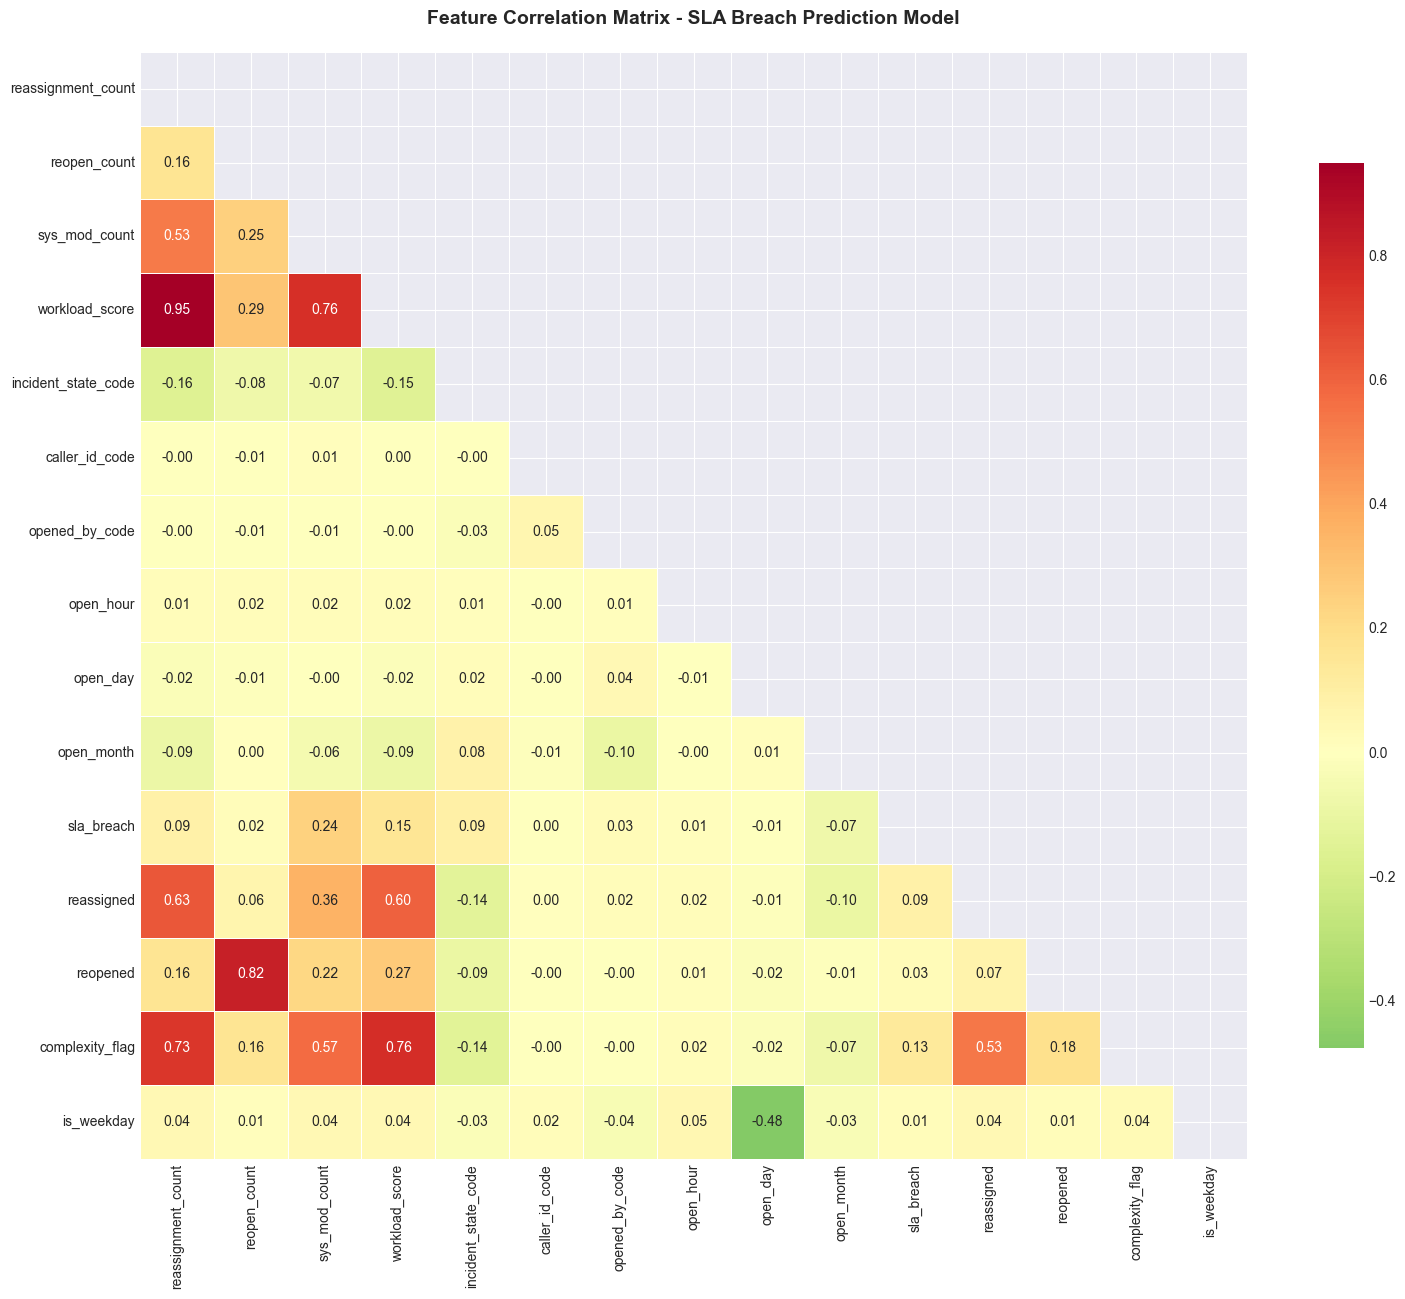

In [11]:
print("\n" + "*" * 80)
print("CORRELATION & FEATURE IMPORTANCE")
print("*" * 80)

# Build correlation matrix
analysis_features = scale_features + ['sla_breach', 'reassigned', 'reopened', 
                                      'complexity_flag', 'is_weekday']
corr_matrix = df_processed[analysis_features].corr()

print("\n>>> Features Most Correlated with SLA Breach:")
breach_correlations = corr_matrix['sla_breach'].sort_values(ascending=False)
print(breach_correlations.head(12))

# Heatmap visualization
plt.figure(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix - SLA Breach Prediction Model', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# STEP 9: EXPORT & SUMMARY

In [12]:
print("\n" + "*" * 80)
print("FINAL PROCESSING SUMMARY")
print("*" * 80)

print(f"\n>>> Dataset Transformation:")
print(f"  Original Size: {df.shape}")
print(f"  Processed Size: {df_processed.shape}")
print(f"  Features Added: {df_processed.shape[1] - df.shape[1]}")
print(f"  Records Removed: {len(df) - len(df_processed)}")

print(f"\n>>> Key Dataset Characteristics:")
print(f"  Unique Incidents: {df_processed['number'].nunique()}")
print(f"  Unique Callers: {df_processed['caller_id'].nunique()}")
print(f"  Unique Openers: {df_processed['opened_by'].nunique()}")
print(f"  Incident States: {df_processed['incident_state'].nunique()}")

if df_processed['opened_at'].notna().any():
    print(f"\n>>> Temporal Coverage:")
    print(f"  From: {df_processed['opened_at'].min()}")
    print(f"  To: {df_processed['opened_at'].max()}")

print(f"\n>>> Target Distribution:")
print(f"  SLA Compliant: {(df_processed['sla_breach']==0).sum()} ({(1-df_processed['sla_breach'].mean())*100:.2f}%)")
print(f"  SLA Breached: {(df_processed['sla_breach']==1).sum()} ({df_processed['sla_breach'].mean()*100:.2f}%)")

print(f"\n>>> Predictive Features Summary:")
print(f"  Incidents with Reassignments: {df_processed['reassigned'].sum()} ({df_processed['reassigned'].mean()*100:.1f}%)")
print(f"  Incidents with Reopens: {df_processed['reopened'].sum()} ({df_processed['reopened'].mean()*100:.1f}%)")
print(f"  High Complexity Incidents: {df_processed['complexity_flag'].sum()} ({df_processed['complexity_flag'].mean()*100:.1f}%)")

# Export processed data
export_filename = 'sla_breach_prediction_dataset.csv'
df_processed.to_csv(export_filename, index=False)

print(f"\n✓ Processed dataset exported: '{export_filename}'")
print("\n" + "*" * 80)
print("PREPROCESSING COMPLETE")
print("*" * 80)


********************************************************************************
FINAL PROCESSING SUMMARY
********************************************************************************

>>> Dataset Transformation:
  Original Size: (141712, 37)
  Processed Size: (141712, 50)
  Features Added: 13
  Records Removed: 0

>>> Key Dataset Characteristics:
  Unique Incidents: 24918
  Unique Callers: 5245
  Unique Openers: 208
  Incident States: 9

>>> Temporal Coverage:
  From: 2016-02-29 01:16:00
  To: 2017-02-16 14:17:00

>>> Target Distribution:
  SLA Compliant: 132497 (93.50%)
  SLA Breached: 9215 (6.50%)

>>> Predictive Features Summary:
  Incidents with Reassignments: 71836 (50.7%)
  Incidents with Reopens: 2314 (1.6%)
  High Complexity Incidents: 34045 (24.0%)

✓ Processed dataset exported: 'sla_breach_prediction_dataset.csv'

********************************************************************************
PREPROCESSING COMPLETE
*******************************************************